In [4]:
# Import the torch library
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
import torch.optim as optim


In [5]:
# Step 2: Load the dataset from Google Drive
import os

#  path to dataset on Google Drive
dataset_path = 'ImageToImage/train'

# Step 3: Define a custom dataset

# Define data transformations
transform = transforms.Compose([transforms.Resize((128,128)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])


class ImageTranslationDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.rgb_images = os.listdir(os.path.join(root, 'rgb'))
        self.thermal_images = os.listdir(os.path.join(root, 'thermal'))

    def __len__(self):
        return min(len(self.rgb_images), len(self.thermal_images))

    def __getitem__(self, idx):
        rgb_img_name = os.path.join(self.root, 'rgb', self.rgb_images[idx])
        thermal_img_name = os.path.join(self.root, 'thermal', self.rgb_images[idx])  # Assumes filenames match

        rgb_image = Image.open(rgb_img_name)
        thermal_image = Image.open(thermal_img_name)

        if self.transform:
            rgb_image = self.transform(rgb_image)
            thermal_image = self.transform(thermal_image)

        return rgb_image, thermal_image

In [6]:
#  Create data loader
batch_size = 16
dataset = ImageTranslationDataset(dataset_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
import torch
import torch.nn as nn

# Define the Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Define the architecture for the generator
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # Add more layers as needed
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
            # Add more layers as needed
        )

    def forward(self, x):
        # Implement the forward pass of the generator
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Define the architecture for the discriminator
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # Add more layers as needed
            nn.Conv2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Implement the forward pass of the discriminator
        out = self.model(x)
        return out

# Create instances of the Generator and Discriminator
generator = Generator()
discriminator = Discriminator()

In [8]:
import torch
import torch.nn as nn

# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        x += residual

        return x

# Ask for confirmation before proceeding to the next cell
#print("Proceed to cell 2/6? (y/n)")

In [6]:

# Define the generator
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, num_res_blocks=1):
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        for i in range(num_res_blocks):
            self.encoder.add_module(f"res_block_{i}", ResidualBlock(64, 64))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        for i in range(num_res_blocks):
            self.decoder.add_module(f"res_block_{i}", ResidualBlock(64, 64))

        self.output = nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.output(x)

        return x

# Ask for confirmation before proceeding to the next cell
#print("Proceed to cell 3/6? (y/n)")

In [9]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, num_res_blocks=6):
        super(Discriminator, self).__init__()

        # Define the conv1 layer
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)

        # Define the bn1 and relu layers for the conv1 layer
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Add the residual blocks
        self.model = nn.Sequential()
        for i in range(num_res_blocks):
            self.model.add_module(f"res_block_{i}", ResidualBlock(64, 64))

        # Define the conv2 layer
        self.conv2 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

        # Define the bn2 and sigmoid layers for the conv2 layer
        self.bn2 = nn.BatchNorm2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass the input image through the conv1 layer
        x = self.conv1(x)

        # Forward pass the input image through the bn1 and relu layers
        x = self.bn1(x)
        x = self.relu(x)

        # Forward pass the input image through the residual blocks
        x = self.model(x)

        # Forward pass the input image through the conv2 layer
        x = self.conv2(x)

        # Forward pass the input image through the bn2 and sigmoid layers
        x = self.bn2(x)
        x = self.sigmoid(x)

        # Return the output of the model
        return x



In [10]:
# Create instances of the Generator and Discriminator
generator = Generator()
discriminator = Discriminator()

In [10]:
import os
import cv2
import numpy as np
from PIL import Image
import torch.optim as optim

# Directory to save model checkpoints
model_checkpoint_directory = 'ImageToImage/model_checkpoints1'
os.makedirs(model_checkpoint_directory, exist_ok=True)

# Define the loss function for your task (e.g., mean squared error)
criterion = nn.MSELoss()

# Define the learning rate and create optimizers for the generator and discriminator
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Define the number of training epochs
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    for i, (real_rgb, real_thermal) in enumerate(data_loader):
        # Check if GPU is available, otherwise use CPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Now, you can move tensors to the device
        # Create instances of the Generator and Discriminator
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        generator = Generator().to(device)
        discriminator = Discriminator().to(device)

        real_rgb = real_rgb.to(device)
        real_thermal = real_thermal.to(device)

        # Training the discriminator
        optimizer_D.zero_grad()

        # Forward pass with real thermal images

        output_real = discriminator(real_thermal)
        loss_real = criterion(output_real, torch.ones_like(output_real))

        # Generate fake thermal images with the generator
        fake_thermal = generator(real_rgb)




        def convert_to_3_channels(image):
          """Converts an image with 1 channel to an image with 3 channels.

          Args:
            image: A torch.Tensor with shape [batch_size, channels, height, width].

          Returns:
            A torch.Tensor with shape [batch_size, 3, height, width].
          """

          batch_size, channels, height, width = image.size()
          image = image.repeat(1, 3, 1, 1)
          return image

        # Convert the fake thermal image to have 3 channels.
        fake_thermal_3_channels = convert_to_3_channels(fake_thermal)

        # Forward pass the converted image through the discriminator model.
        output_fake = discriminator(fake_thermal_3_channels)

        # # Forward pass with fake thermal images
        # output_fake = discriminator(fake_thermal.detach())
        loss_fake = criterion(output_fake, torch.zeros_like(output_fake))

        # Total discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Training the generator
        optimizer_G.zero_grad()

        # Generate fake thermal images with the generator
        fake_thermal = generator(real_rgb)

        # Forward pass with fake thermal images
        output_fake = discriminator(fake_thermal_3_channels)


        # Generator loss
        loss_G = criterion(output_fake, torch.ones_like(output_fake))

        # Backward through the graph
        # loss_G.backward(retain_graph=True)

        # Update the generator parameters
        optimizer_G.step()

        # # Generator loss
        # loss_G = criterion(output_fake, torch.ones_like(output_fake))
        # loss_G.backward()
        # optimizer_G.step()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(data_loader)}], Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}')

        # Save the generator and discriminator models every 20 epochs
        if (epoch + 1) % 20 == 0:
            generator_path = os.path.join(model_checkpoint_directory, f'generator_epoch{epoch}.pth')
            discriminator_path = os.path.join(model_checkpoint_directory, f'discriminator_epoch{epoch}.pth')
            torch.save(generator.state_dict(), generator_path)
            torch.save(discriminator.state_dict(), discriminator_path)

Epoch [0/50], Step [9/63], Loss_D: 0.5779, Loss_G: 0.2788
Epoch [0/50], Step [19/63], Loss_D: 0.5745, Loss_G: 0.2780
Epoch [0/50], Step [29/63], Loss_D: 0.5724, Loss_G: 0.2703
Epoch [0/50], Step [39/63], Loss_D: 0.5649, Loss_G: 0.2786
Epoch [0/50], Step [49/63], Loss_D: 0.5761, Loss_G: 0.2892
Epoch [0/50], Step [59/63], Loss_D: 0.5652, Loss_G: 0.2992
Epoch [1/50], Step [9/63], Loss_D: 0.5688, Loss_G: 0.2720
Epoch [1/50], Step [19/63], Loss_D: 0.5668, Loss_G: 0.2724
Epoch [1/50], Step [29/63], Loss_D: 0.5650, Loss_G: 0.2802
Epoch [1/50], Step [39/63], Loss_D: 0.5875, Loss_G: 0.2692
Epoch [1/50], Step [49/63], Loss_D: 0.5719, Loss_G: 0.2764
Epoch [1/50], Step [59/63], Loss_D: 0.5686, Loss_G: 0.2991
Epoch [2/50], Step [9/63], Loss_D: 0.5742, Loss_G: 0.2913
Epoch [2/50], Step [19/63], Loss_D: 0.5661, Loss_G: 0.2947
Epoch [2/50], Step [29/63], Loss_D: 0.5670, Loss_G: 0.2839
Epoch [2/50], Step [39/63], Loss_D: 0.5713, Loss_G: 0.2836
Epoch [2/50], Step [49/63], Loss_D: 0.5671, Loss_G: 0.2766


Step 3: using validation dataset on our trained model 

After training, we can use our trained generator to generate images as below:

In [15]:
import torch
import torch.nn.functional as F

def psnr(prediction, target, max_val=1.0):
    mse = F.mse_loss(prediction, target)
    psnr = 10 * torch.log10((max_val ** 2) / mse)
    return psnr

In [16]:

import torch
import torch.nn as nn

# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        x += residual

        return x

# Ask for confirmation before proceeding to the next cell
print("Proceed to cell 2/6? (y/n)")


# Define the generator
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, num_res_blocks=1):
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        for i in range(num_res_blocks):
            self.encoder.add_module(f"res_block_{i}", ResidualBlock(64, 64))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        for i in range(num_res_blocks):
            self.decoder.add_module(f"res_block_{i}", ResidualBlock(64, 64))

        self.output = nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.output(x)

        return x

# Ask for confirmation before proceeding to the next cell
print("Proceed to cell 3/6? (y/n)")


import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, num_res_blocks=6):
        super(Discriminator, self).__init__()

        # Define the conv1 layer
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)

        # Define the bn1 and relu layers for the conv1 layer
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Add the residual blocks
        self.model = nn.Sequential()
        for i in range(num_res_blocks):
            self.model.add_module(f"res_block_{i}", ResidualBlock(64, 64))

        # Define the conv2 layer
        self.conv2 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

        # Define the bn2 and sigmoid layers for the conv2 layer
        self.bn2 = nn.BatchNorm2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass the input image through the conv1 layer
        x = self.conv1(x)

        # Forward pass the input image through the bn1 and relu layers
        x = self.bn1(x)
        x = self.relu(x)

        # Forward pass the input image through the residual blocks
        x = self.model(x)

        # Forward pass the input image through the conv2 layer
        x = self.conv2(x)

        # Forward pass the input image through the bn2 and sigmoid layers
        x = self.bn2(x)
        x = self.sigmoid(x)

        # Return the output of the model
        return x

# Diagram of the Discriminator class:



Proceed to cell 2/6? (y/n)
Proceed to cell 3/6? (y/n)


In [17]:
# Define the path to the validation dataset
val_dataset_path = 'ImageToImage/val'

# Define a custom dataset class for validation
class ValidationImageTranslationDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.rgb_images = os.listdir(os.path.join(root, 'rgb'))
        self.thermal_images = os.listdir(os.path.join(root, 'thermal'))

    def __len__(self):
        return min(len(self.rgb_images), len(self.thermal_images))

    def __getitem__(self, idx):
        rgb_img_name = os.path.join(self.root, 'rgb', self.rgb_images[idx])
        thermal_img_name = os.path.join(self.root, 'thermal', self.thermal_images[idx])

        rgb_image = Image.open(rgb_img_name)
        thermal_image = Image.open(thermal_img_name)

        if self.transform:
            rgb_image = self.transform(rgb_image)
            thermal_image = self.transform(thermal_image)

        return rgb_image, thermal_image, os.path.basename(thermal_img_name)  # Include the image filename


# Create a data loader for validation
batch_size = 16
validation_dataset = ValidationImageTranslationDataset(val_dataset_path, transform=transform)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# Define the loss function for your task (e.g., mean squared error)
criterion = nn.MSELoss()
# Load the trained generator model

generator = Generator()  # Replace with your trained generator model
generator.load_state_dict(torch.load('ImageToImage/model_checkpoints1/generator_epoch39.pth'))
generator.eval()

# Move the generator model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)

# Validation loop
validation_loss = 0.0
total_psnr = 0.0
num_samples = 0

# Create a directory to save the generated thermal images from the validation dataset
gen_val_directory = 'newgenerated_val1'
os.makedirs(gen_val_directory, exist_ok=True)

with torch.no_grad():
    for i, (real_rgb, real_thermal, image_filename) in enumerate(validation_data_loader):
        real_rgb = real_rgb.to(device)
        real_thermal = real_thermal.to(device)

        # Generate fake thermal images with the generator
        fake_thermal = generator(real_rgb)  # Move back to CPU for image saving



        def convert_to_3_channels(image):
          """Converts an image with 1 channel to an image with 3 channels.

          Args:
            image: A torch.Tensor with shape [batch_size, channels, height, width].

          Returns:
            A torch.Tensor with shape [batch_size, 3, height, width].
          """

          batch_size, channels, height, width = image.size()
          image = image.repeat(1, 3, 1, 1)
          return image

        # Convert the fake thermal image to have 3 channels.
        fake_thermal = convert_to_3_channels(fake_thermal)

       

        for j in range(fake_thermal.size(0)):
            image = fake_thermal[j].permute(1, 2, 0).numpy()

            # Convert the image values from (-1, 1) to (0, 1)
            image = (image + 1) / 2

            # Save the generated thermal image using the original image filename
            generated_image_filename = os.path.join(gen_val_directory, image_filename[j])
            Image.fromarray((image * 255).astype(np.uint8)).save(generated_image_filename)

        # Calculate the PSNR
        psnr_batch = psnr(real_thermal, fake_thermal)
        total_psnr += psnr_batch.sum().item()

        # Calculate the loss (e.g., MSE) between real thermal and generated thermal
        validation_loss += criterion(fake_thermal, real_thermal).item()

        num_samples += real_rgb.size(0)

# Calculate the average PSNR and validation loss
average_psnr = total_psnr / num_samples
average_validation_loss = validation_loss / num_samples

print(f'Average PSNR: {average_psnr:.4f}')
print(f'Average Validation Loss: {average_validation_loss:.4f}')
print(f'Generated images saved in: {gen_val_directory}')

Average PSNR: -0.1250
Average Validation Loss: 0.1011
Generated images saved in: newgenerated_val1


In [18]:
import cv2
import os
import pandas as pd
from tqdm.auto import tqdm
# To convert images to Row-Major Format
def row_major_enc(img):
    lst = []
    H,W,C = img.shape
    for i in range(C):
        for j in range(W):
            for k in range(H):
                lst.append(img[k][j][i])
    return lst
# Creating a submission.csv
BASE = "newgenerated_val1" # wherever saved predictions image from val
val_rgb_lst = os.listdir(BASE)
subDict = {"ID":[], "RMImg": []}

for im_name in tqdm(val_rgb_lst):
    img = cv2.imread(os.path.join(BASE, im_name))
    rme_img = row_major_enc(img)

    subDict["ID"].append(im_name)
    subDict["RMImg"].append(rme_img)

subPd = pd.DataFrame({"ID": [x for x in subDict["ID"]],
                      "RMImg": [x for x in subDict["RMImg"]]})

subPd.to_csv("newsubmission1.csv", index=False)

  0%|          | 0/201 [00:00<?, ?it/s]

# Visualize some generated images corresponding to the rgb images


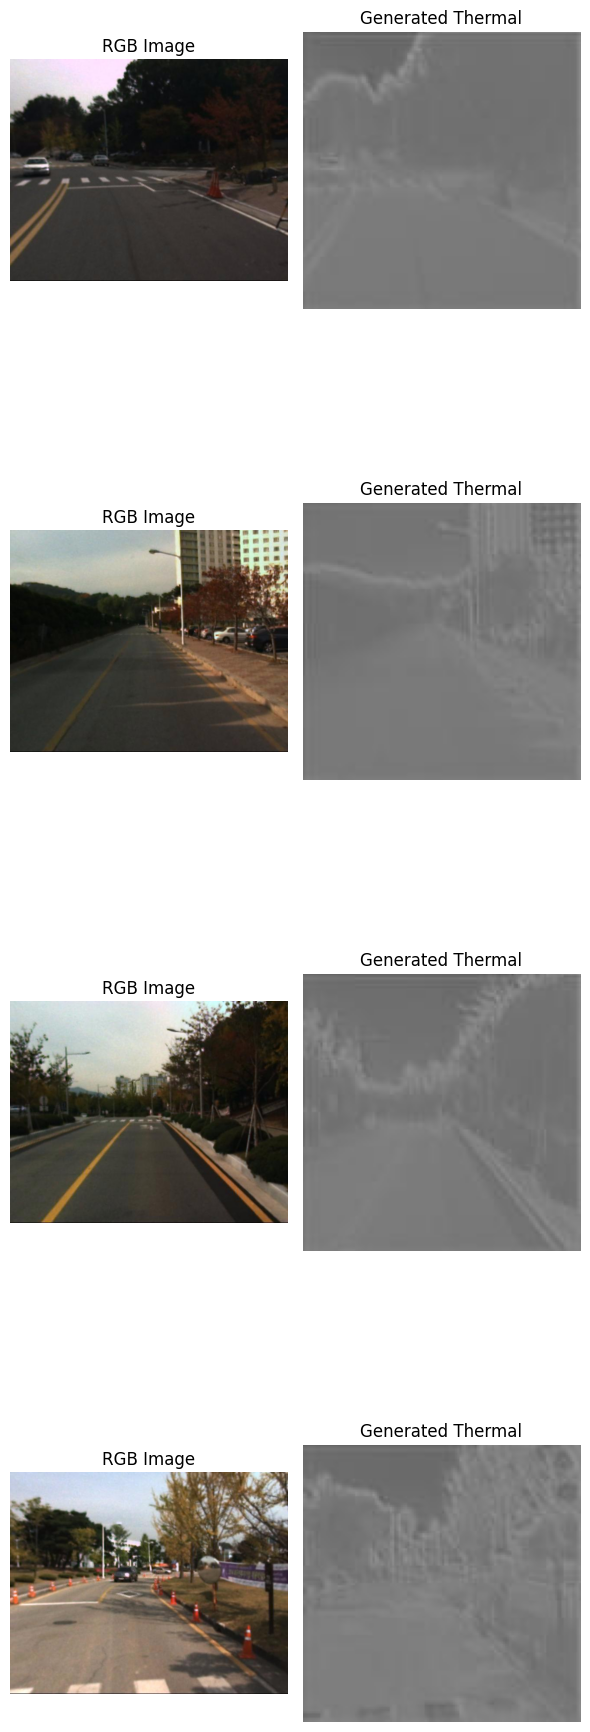

In [25]:
import matplotlib.pyplot as plt
import os
import cv2

# Directories containing your images
rgb_directory = 'ImageToImage/val/rgb'  
thermal_directory = 'newgenerated_val1'  
# List the files in the directories
rgb_images = os.listdir(rgb_directory)
thermal_images = os.listdir(thermal_directory)

# Take up to 4 pairs for visualization
num_pairs = min(4, min(len(rgb_images), len(thermal_images)))

# Plotting the image pairs
fig, axes = plt.subplots(num_pairs, 2, figsize=(6, num_pairs * 5))

for i in range(num_pairs):
    # Read the images
    rgb_image = cv2.imread(os.path.join(rgb_directory, rgb_images[i]))
    thermal_image = cv2.imread(os.path.join(thermal_directory, thermal_images[i]))

    # Convert BGR to RGB
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    thermal_image = cv2.cvtColor(thermal_image, cv2.COLOR_BGR2RGB)

    # Plot the images
    axes[i, 0].imshow(rgb_image)
    axes[i, 0].set_title('RGB Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(thermal_image)
    axes[i, 1].set_title('Generated Thermal')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()